In [68]:
import torch
import random
from typing import Tuple

def generate_coin_flip_dataset(N: int, M: int, train_ratio: float = 0.8, seed: int = 10
) -> Tuple[Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
    """
    Generate dataset from coin flip experiment.
    
    Args:
        N (int): Half the total number of coins. Total coins = 2N
        M (int): Number of experiments (samples)
        train_ratio (float): Ratio of data to be used as training
        seed (int): Random seed for reproducibility
    
    Returns:
        ((X_train, y_train), (X_test, y_test)): Tuple of training and test sets
    """
    random.seed(seed)
    torch.manual_seed(seed)

    total_coins = 2 * N
    probabilities = torch.tensor([(i + 1) / total_coins for i in range(total_coins)])  # i from 1 to 2N

    inputs = []
    outputs = []

    for _ in range(M):
        selected_indices = random.sample(range(total_coins), N)
        selected_probs = probabilities[selected_indices]

        # Simulate flips: 1 for heads (upside), 0 for tails
        flips = torch.bernoulli(selected_probs).int()
        total_upsides = flips.sum().item()

        inputs.append(torch.tensor(selected_indices))
        outputs.append(total_upsides)

    X = torch.stack(inputs)              # (M, N)
    y = torch.tensor(outputs).unsqueeze(1)  # (M, 1)

    # Shuffle and split
    perm = torch.randperm(M)
    train_size = int(M * train_ratio)
    train_idx = perm[:train_size]
    test_idx = perm[train_size:]

    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return (X_train, y_train), (X_test, y_test)

# Example usage:
if __name__ == "__main__":
    N = 2     # Half of total coins
    M = 20000   # Number of samples
    (X_train, y_train), (X_test, y_test) = generate_coin_flip_dataset(N, M)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------------------
# 1) Simple Dataset for (X: M×N) -> (y: M×1)
# -----------------------------------------
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------------------------------
# 2) Transformer‑based regressor with 8 encoder layers
# ---------------------------------------------------
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8,
                 num_layers=8, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(1)              
        x = self.input_proj(x)           
        x_enc = self.transformer_encoder(x)  
        x_enc = x_enc.permute(0, 2, 1)      
        x_pooled = self.pool(x_enc).squeeze(-1)  
        return self.fc_out(x_pooled)          

# -------------------------
# 3) Training
# -------------------------
def train(model, dataloader, epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f}")

import math

def poisson_binomial_probability(selected_indices, Y):
    """
    Compute P(exactly Y ups) for coins with indices in selected_indices,
    where coin i has probability i/(2N) of landing 'up'.

    Args:
        selected_indices (list of int): the i-values of the N selected coins.
        Y (int): the desired number of ups.

    Returns:
        float: probability of exactly Y ups.
    """
    N = len(selected_indices)
    # Compute p_j = i / (2N) for each selected coin
    p = [i / (2*N) for i in selected_indices]

    # dp[k] will hold the probability of k ups
    dp = [0.0] * (N + 1)
    dp[0] = 1.0

    # Update DP for each coin
    for prob in p:
        # iterate k from high to low so we don't overwrite needed values
        for k in range(N, -1, -1):
            no_up = dp[k] * (1 - prob)
            up = dp[k-1] * prob if k > 0 else 0.0
            dp[k] = no_up + up

    return dp[Y]

def evaluate(model, X_test, y_test, batch_size=32, device='cpu'):
    """
    Evaluates the TransformerRegressor on test data.

    Args:
        model: trained TransformerRegressor
        X_test: torch.Tensor of shape (M_test, N)
        y_test: torch.Tensor of shape (M_test, 1)
        batch_size: batch size for evaluation loader
        device: 'cpu' or 'cuda'
    """
    model.to(device)
    model.eval()

    # Create DataLoader for test set
    test_dataset = SimpleDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    all_probs = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device)

            preds = math.ceil(model(X_batch).to(device))   # [batch_size, 1]
            X_batch = X_batch.int()
            X_batch = torch.squeeze(X_batch,0)
            X_batch = X_batch.tolist()
            c_prob = poisson_binomial_probability(X_batch, preds)
            all_probs.append(c_prob)

    # Concatenate all batches
    prob = sum(all_probs)/len(all_probs)

    print(f"Average Conditional Probability: {prob}")

    return prob

In [ ]:
import matplotlib.pyplot as plt

def train_and_eval(model, 
                   X_train, y_train, 
                   X_val, y_val,
                   epochs=10, lr=1e-3, 
                   batch_size=32,
                   device='cpu',
                   save_path='train_val_plot.svg'):
    """
    Train the model and evaluate on validation set at each epoch.
    Tracks training loss and validation probability, then plots both vs. epoch as vector diagram.
    Saves the plot to `save_path` in SVG format.
    """
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_dataset = SimpleDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = SimpleDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    train_losses = []
    val_probs = []

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        total_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # --- Evaluation ---
        model.eval()
        all_probs = []
        with torch.no_grad():
            for X_batch, _ in val_loader:
                X_int = X_batch.to(device).int().squeeze(0)
                pred = model(X_batch.to(device).float())
                pred_k = math.ceil(pred.item())
                indices = X_int.tolist()
                prob = poisson_binomial_probability(indices, pred_k)
                all_probs.append(prob)
        avg_prob = sum(all_probs) / len(all_probs)
        val_probs.append(avg_prob)

        print(f"Epoch {epoch}/{epochs} — Train Loss: {avg_train_loss:.4f} — Val Avg Prob: {avg_prob:.4f}")

    # --- Plotting ---
    epochs_range = list(range(1, epochs + 1))
    plt.figure()
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_probs, label='Val Avg Prob')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title('Training Loss and Validation Probability vs. Epoch')
    plt.legend()
    plt.savefig(save_path, format='svg')
    plt.show()

    return model, train_losses, val_probs

In [ ]:
# -----------------------------------------------------
# 4) Usage on data (M=1000, N=20)
# -----------------------------------------------------
if __name__ == "__main__":
    X = X_train
    y = y_train

    dataset = SimpleDataset(X, y)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = TransformerRegressor(input_dim=N)
    train(model, loader, epochs=40, lr=1e-3)

In [ ]:


# -------------------------------
# Example usage after training:
# -------------------------------
if __name__ == "__main__":

    prob = evaluate(model, X_test, y_test, batch_size=32, device='cpu')

In [71]:
model = TransformerRegressor(input_dim=N)

In [ ]:

trained_model,train_losses, val_probs = train_and_eval(
    model,
    X_train, y_train,
    X_val=X_test, y_val=y_test,
    epochs=20,
    lr=1e-4,
    batch_size=64,
    device='cuda'  
)

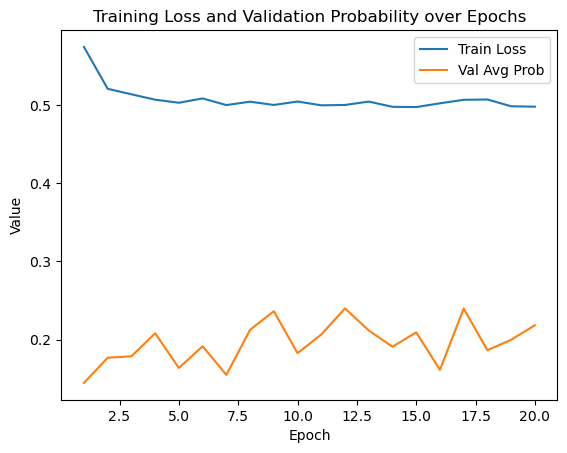

In [ ]:
epochs_range = list(range(1, 20 + 1))
plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_probs, label='Val Avg Prob')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Validation Probability over Epochs')
plt.legend()
plt.savefig("1.svg", format='svg')
plt.show()